<a href="https://colab.research.google.com/github/manuel-suarez/tensorflow_examples/blob/main/TensorFlow_examples_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example for [TensorFlow - CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan?hl=en)

## [Setup](https://www.tensorflow.org/tutorials/generative/cyclegan?hl=en#set_up_the_input_pipeline)

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wws7j2q1
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-wws7j2q1
  Created wheel for tensorflow-examples: filename=tensorflow_examples-5d3579cb1057d31c260be4289a32ebc0a91782e0_-py3-none-any.whl size=299669 sha256=c9c39b1d74d7756c50394dac0a2df86cfe05d8c6ed305dd9dfd6df785a19faa1
  Stored in directory: /tmp/pip-ephem-wheel-cache-k0p_jy3x/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## [Input pipeline](https://www.tensorflow.org/tutorials/generative/cyclegan?hl=en#input_pipeline)

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4574KI/cycle_gan-trainA.tfrecord*...:   …

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4574KI/cycle_gan-trainB.tfrecord*...:   …

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4574KI/cycle_gan-testA.tfrecord*...:   0…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete4574KI/cycle_gan-testB.tfrecord*...:   0…

Dataset cycle_gan downloaded and prepared to ~/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

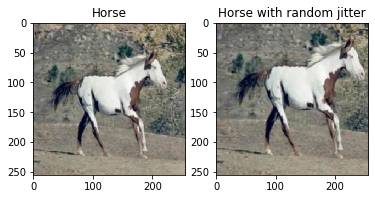

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)